In [1]:
import os
os.chdir("../../../../")

In [2]:
os.environ['CUDA_VISIBLE_DEVICES'] = str(2)

In [3]:
import jax
import jax.numpy as jnp
import numpy as np
import flax.linen as nn
import optax
import pandas as pd
from functools import partial
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from utilities.fits import fit
from datasets.dataset_loader import dataset_load
from utilities import plot, gmm, errors, predict, preprocess
from utilities.recalibration_conformal import *
from models import seq2point_gaussian
import scipy.stats as st
from mapie.metrics import regression_coverage_score
from sklearn.isotonic import IsotonicRegression
from tueplots import bundles
os.environ["XLA_FLAGS"] = "--xla_gpu_deterministic_reductions --xla_gpu_autotune_level=2"
os.environ['TF_CUDNN_DETERMINISTIC'] = '1'

# Model Training

In [4]:
train = {
    1: {
        'start_time': "2011-04-28",
        'end_time': "2011-05-15"
    },
    3: {
        'start_time': "2011-04-19",
        'end_time': "2011-05-22"
    }
}
test = {
    2: {
        'start_time': "2011-04-21",
        'end_time': "2011-05-21"
    }
}
appliances = ["Dish Washer"]

In [5]:
datas = dataset_load(appliances, train, test, 99, split_factor=0.25)
x_train, y_train = datas[0], datas[1]
x_cal, y_cal = datas[2], datas[3]
x_test, y_test = datas[4], datas[5]
x_test_timestamp = datas[6]
scaler_x, scaler_y = datas[7], datas[8]

In [6]:
training_predictions_df = pd.DataFrame()
testing_predictions_df = pd.DataFrame()
calibration_predictions_df = pd.DataFrame()
training_predictions_df["Ground Truth"] = scaler_y.inverse_transform(y_train)[
    :, 0]
calibration_predictions_df['Ground Truth'] = scaler_y.inverse_transform(y_cal)[
    :, 0]
testing_predictions_df["Timestamp"] = x_test_timestamp
testing_predictions_df["Ground Truth"] = y_test

In [7]:
model = seq2point_gaussian.seq2point()

In [8]:
%%capture cap --no-stderr
%%time
params =  model.init(jax.random.PRNGKey(0), x_train, True)
params, losses = fit(model, params, x_train, y_train, False, batch_size=1024, learning_rate=0.0001, epochs=50)

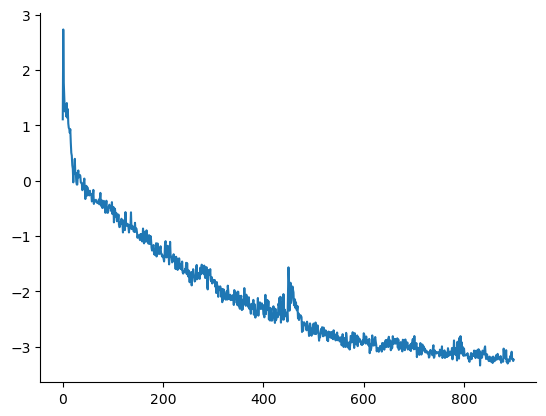

In [9]:
plt.plot(losses)
sns.despine()

In [10]:
mlp_training_time = cap.stdout.split('\n')[1]
mlp_training_time

'Wall time: 10.8 s'

In [11]:
n_stacks = 10


def fn(x, i): return model.apply(params, x, False,
                                 rngs={"dropout": jax.random.PRNGKey(i)})

# Before Calibration

##### Results on Calibration Set

In [12]:
%%capture cap
%%time
y_stacks_cal = jax.vmap(jax.jit(fn), in_axes=(None, 0))(
    x_cal, jnp.arange(n_stacks))

In [13]:
mc_cal_mean, mc_cal_sigma = gmm.gmm_mean_var(y_stacks_cal[0], y_stacks_cal[1])

In [14]:
mc_cal_mean = scaler_y.inverse_transform(mc_cal_mean)
mc_cal_sigma = (scaler_y.scale_*mc_cal_sigma)
y_true_cal = scaler_y.inverse_transform(y_cal)

In [15]:
print(f"RMSE : {errors.rmse(y_true_cal, mc_cal_mean):.4f} MAE  : {errors.mae(y_true_cal, mc_cal_mean):.4f} NLL : {errors.NLL(mc_cal_mean,mc_cal_sigma,y_true_cal):.4f}")

RMSE : 78.3064 MAE  : 9.8777 NLL : 1.3641


In [16]:
calibration_predictions_df['MC_Mean'] = mc_cal_mean
calibration_predictions_df['MC_Sigma'] = mc_cal_sigma

In [17]:
mlp_calibration_time = cap.stdout.split('\n')[1]
mlp_calibration_time

'Wall time: 1.21 s'

##### Results on Training Set

In [18]:
y_stacks_train = jax.vmap(jax.jit(fn), in_axes=(None, 0))(
    x_train, jnp.arange(n_stacks))

In [19]:
mc_train_mean, mc_train_sigma = gmm.gmm_mean_var(
    y_stacks_train[0], y_stacks_train[1])

In [20]:
mc_train_mean = scaler_y.inverse_transform(mc_train_mean)
mc_train_sigma = (scaler_y.scale_*mc_train_sigma)
y_train_scaled = scaler_y.inverse_transform(y_train)

In [21]:
print(f"RMSE : {errors.rmse(y_train_scaled, mc_train_mean):.4f}", f"MAE  : {errors.mae(y_train_scaled, mc_train_mean):.4f}",
      f"NLL  : {errors.NLL(mc_train_mean, mc_train_sigma, y_train_scaled):.4f}")

RMSE : 86.1567 MAE  : 11.5830 NLL  : 1.3888


In [22]:
training_predictions_df['MC_mean'] = mc_train_mean
training_predictions_df['MC_sigma'] = mc_train_sigma

##### Results on Test Set

In [23]:
%%capture cap
%%time
y_stacks_test = jax.vmap(jax.jit(fn), in_axes=(
    None, 0))(x_test, jnp.arange(n_stacks))

In [24]:
mc_test_mean, mc_test_sigma = gmm.gmm_mean_var(
    y_stacks_test[0], y_stacks_test[1])

In [25]:
mc_test_mean = scaler_y.inverse_transform(mc_test_mean)
mc_test_sigma = (scaler_y.scale_*mc_test_sigma)

In [26]:
print(f"RMSE : {errors.rmse(y_test, mc_test_mean):.4f}", f"MAE  : {errors.mae(y_test, mc_test_mean):.4f}",
      f"NLL  : {errors.NLL(mc_test_mean, mc_test_sigma, y_test):.4f}")

RMSE : 93.0097 MAE  : 9.2896 NLL  : 1.8267


In [27]:
testing_predictions_df['MC_Mean'] = mc_test_mean
testing_predictions_df['MC_Sigma'] = mc_test_sigma

In [28]:
mlp_testing_time = cap.stdout.split('\n')[1]
mlp_testing_time

'Wall time: 2.84 s'

In [29]:
training_predictions_df.to_csv(
    "notebooks/dishwasher/s2p/gmlp/preds/training_predictions_mc.csv", index=False)
calibration_predictions_df.to_csv(
    "notebooks/dishwasher/s2p/gmlp/preds/calibration_predictions_mc.csv", index=False)
testing_predictions_df.to_csv(
    "notebooks/dishwasher/s2p/gmlp/preds/testing_predictions_mc.csv", index=False)

# After Calibration

In [30]:
recalibration_df = pd.DataFrame()

### Isotonic Regression

In [31]:
def ace(ideal, predicted):
    """
    dataframe : pandas dataframe with Ideal and Counts as column for regression calibration
    It can be directly used as 2nd output from calibration_regression in plot.py 
    """
    def rmse_loss(y, yhat):
        return jnp.abs(y-yhat)
    return jnp.mean(jax.vmap(rmse_loss, in_axes=(0, 0))(ideal, predicted))

In [32]:
%%capture cap
%%time
series_train = find_p_hat(y_train_scaled, mc_train_mean, mc_train_sigma)
series_test = find_p_hat(y_test, mc_test_mean, mc_test_sigma)
series_cal = find_p_hat(y_true_cal, mc_cal_mean, mc_cal_sigma)

In [33]:
isotonic_1 = cap.stdout.split('\n')[1]
isotonic_1

'Wall time: 1.04 s'

In [34]:
%%capture cap
%%time
calibrator = IsotonicRegression(out_of_bounds='clip')
calibrator.fit(series_cal.values, series_cal.index)

In [35]:
isotonic_2 = cap.stdout.split('\n')[1]
isotonic_2

'Wall time: 1.81 ms'

In [36]:
%%capture cap
%%time
p = series_cal.index
new_p = calibrator.predict(series_cal.index)

In [37]:
isotonic_3 = cap.stdout.split('\n')[1]
isotonic_3

'Wall time: 324 us'

In [38]:
%%capture cap
%%time
new_p_hat_train = find_new_p_hat(
    y_train_scaled, new_p, mc_train_mean, mc_train_sigma)
new_p_hat_cal = find_new_p_hat(y_true_cal, new_p, mc_cal_mean, mc_cal_sigma)
new_p_hat_test = find_new_p_hat(y_test, new_p, mc_test_mean, mc_test_sigma)

In [39]:
isotonic_4 = cap.stdout.split('\n')[1]
isotonic_4

'Wall time: 48.1 ms'

In [40]:
recalibration_df["p"] = p
recalibration_df["phat_mc"] = series_test.values
recalibration_df["new_p_mc"] = new_p
recalibration_df["new_phat_mc"] = new_p_hat_test

In [41]:
recalibration_df.to_csv(
    "notebooks/dishwasher/s2p/gmlp/ic/recalibration_df_mc.csv", index=False)

In [42]:
train_time = float(mlp_training_time[11:14])
calibration_time = float(mlp_calibration_time[11:15])
isotonic_time_final = float(
    isotonic_1[11:15]) + float(isotonic_2[11:15])/1000
+ float(isotonic_3[11:14])/1000000 + float(isotonic_4[11:15])/1000

0.048424

In [43]:
total_time = train_time + calibration_time + isotonic_time_final
total_time

12.25181

In [44]:
with open('notebooks/dishwasher/s2p/gmlp/time_hetro_mc.txt', 'w') as file:
    file.writelines([f"MLP training :{mlp_training_time} ", f" MLP Calibration: {mlp_calibration_time}\n"
                     f"Isotonic Time: {isotonic_time_final} ", f"Total time: {total_time}s"])

In [45]:
bundles.icml2022()

{'text.usetex': True,
 'font.family': 'serif',
 'text.latex.preamble': '\\usepackage{times} ',
 'figure.figsize': (3.25, 2.0086104634371584),
 'figure.constrained_layout.use': True,
 'figure.autolayout': False,
 'savefig.bbox': 'tight',
 'savefig.pad_inches': 0.015,
 'font.size': 8,
 'axes.labelsize': 8,
 'legend.fontsize': 6,
 'xtick.labelsize': 6,
 'ytick.labelsize': 6,
 'axes.titlesize': 8}

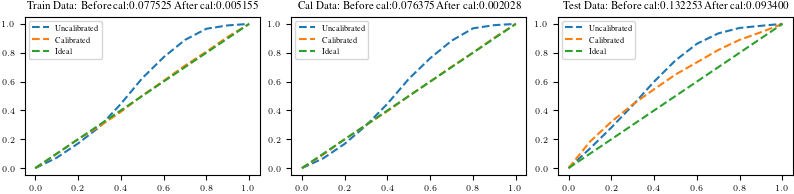

In [46]:
plt.rcParams.update(bundles.icml2022())
plt.rcParams.update({'figure.figsize': (8, 2)})
plt.subplot(1, 3, 1)
plt.plot(p, series_train.values, label='Uncalibrated', linestyle='--')
plt.plot(p, new_p_hat_train, label='Calibrated', linestyle='--')
plt.plot([0, 1], [0, 1], label="Ideal", linestyle='--')
plt.title(
    f"Train Data: Before cal:{ace(p.values,series_train.values):2f} After cal:{ace(p.values,new_p_hat_train):2f}")
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(p, series_cal.values, label='Uncalibrated', linestyle='--')
plt.plot(p, new_p_hat_cal, label='Calibrated', linestyle='--')
plt.plot([0, 1], [0, 1], label="Ideal", linestyle='--')
plt.title(
    f"Cal Data: Before cal:{ace(p.values,series_cal.values):2f} After cal:{ace(p.values,new_p_hat_cal):2f}")
plt.legend()

plt.subplot(1, 3, 3)
plt.plot(p, series_test.values, label='Uncalibrated', linestyle='--')
plt.plot(p, new_p_hat_test, label='Calibrated', linestyle='--')
plt.plot([0, 1], [0, 1], label="Ideal", linestyle='--')
plt.title(
    f"Test Data: Before cal:{ace(p.values,series_test.values):2f} After cal:{ace(p.values,new_p_hat_test):2f}")
plt.legend()
plt.savefig(
    f'/home/haikoo.khandor/haikoo/conformal/con_figures/{appliances[0]}_S2P_Hetero_MC.pdf')